## Analysis of Toronto Parking Ticket Datasets

In [1]:
import pandas as pd 
import os # for files and directories 
import numpy as np

##### Datasets can be accessed here: 
https://www1.toronto.ca/wps/portal/contentonly?vgnextoid=ca20256c54ea4310VgnVCM1000003dd60f89RCRD

##### Dataset format is as below:
    # TAG_NUMBER_MASKED   First three (3) characters masked with asterisks
    #  DATE_OF_INFRACTION  Date the infraction occurred in YYYYMMDD format
    #  INFRACTION_CODE Applicable Infraction code (numeric)
    #  INFRACTION_DESCRIPTION  Short description of the infraction
    #  SET_FINE_AMOUNT Amount of set fine applicable (in dollars)
    #  TIME_OF_INFRACTION  Time the infraction occurred  in HHMM format (24-hr clock)
    #  LOCATION1   Code to denote proximity (see table below)
    #  LOCATION2   Street address
    #  LOCATION3   Code to denote proximity (optional)
    #  LOCATION4   Street address (optional)
    #  PROVINCE    Province or state code of vehicle licence plate

##### We do not use the following table here, but LOCATION1 is coded as below:
    #  Proximity Code Table
    #  PROXIMITY CODE  DESCRIPTION
    #  AT  At
    #  NR  Near
    #  OPP Opposite
    #  R/O Rear of
    #  N/S North Side
    #  S/S South Side
    #  E/S East Side
    #  W/S West Side
    #  N/O North of
    #  S/O South of
    #  E/O East of
    #  W/O West of

First, get_df processes a given dataset (file) and returns the content as a dataframe. 
We also fix and clean the date format for future process

In [2]:
    def get_df(fid):
        dataframe = pd.read_csv(fid, error_bad_lines=False, usecols=[1, 2, 3, 4, 5, 7, 10],
                                dtype={'time_of_infraction': str})  # Note: skip bad lines
        pat = r"\s\bAV\b"
        dataframe.location2 = dataframe.location2.str.replace(pat, ' AVE')

        # update date and time formats
        dataframe.date_of_infraction = pd.to_datetime(dataframe.date_of_infraction, format='%Y%m%d')
        dataframe['year_of_infraction'] = pd.to_datetime(dataframe.date_of_infraction, format='%Y%m%d').dt.year
        dataframe['month_of_infraction'] = pd.to_datetime(dataframe.date_of_infraction, format='%Y%m%d').dt.month
        dataframe['day_of_infraction'] = pd.to_datetime(dataframe.date_of_infraction, format='%Y%m%d').dt.day
        dataframe['quarter_of_infraction'] = pd.to_datetime(dataframe.date_of_infraction, format='%Y%m%d').dt.quarter
        dataframe['weekday_of_infraction'] = pd.to_datetime(dataframe.date_of_infraction,
                                                            format='%Y%m%d').dt.weekday_name

        dataframe.drop(['date_of_infraction'], axis=1, inplace=True)  # no longer useful

        dataframe.time_of_infraction = pd.to_datetime(dataframe['time_of_infraction'].astype(str), format='%H%M',
                                                      errors='coerce')
        dataframe['hour_of_infraction'] = pd.to_datetime(dataframe.time_of_infraction, format='%Y%m%d').dt.hour
        return dataframe

Now, let's apply some groupby operations on the dataframe to extract more useful data.
Note that the extracted columns are saved into an excel format first. The goal is to process all years first and then do some analysis. We save different things in different excel sheets. 

In [3]:
def processTicketDS(directory, dataSet, num_of_dataset):
    outFile = dataSet[:len(dataSet) - 4] + '_Summary.xls'
    if num_of_dataset == 1:
        df = get_df(open(directory + dataSet))
    else:
        dfs = []
        for i in range(1, num_of_dataset + 1):
            dfs.append(get_df(open(directory + dataSet[:len(dataSet) - 4] + '_' + str(i) + '.csv')))
        df = pd.concat(dfs)

    writer = pd.ExcelWriter(outFile)

    data = df.groupby(['infraction_code', 'infraction_description']).size().reset_index().rename(
        columns={0: 'count'}).drop_duplicates(subset='infraction_code', keep="last")
    data.to_excel(writer, 'code_description')

    # Distribution of fines
    data = df.groupby('infraction_code').agg({'set_fine_amount': ['count', 'sum', 'max']})
    data.to_excel(writer, 'Distribution')

    # Infractions by month
    data = df.groupby(['month_of_infraction']).agg(
        {'set_fine_amount': ['count', 'sum', 'max', 'min']})
    data.to_excel(writer, 'Per_month')

    # Infractions by quarter
    data = df.groupby(['quarter_of_infraction']).agg(
        {'set_fine_amount': ['count', 'sum', 'max', 'min']})
    data.to_excel(writer, 'Per_quarter')

    # Infractions by day
    data = df.groupby(['day_of_infraction']).agg(
        {'set_fine_amount': ['count', 'sum']})
    data.to_excel(writer, 'Per_day')

    # Infractions by weekday
    data = df.groupby(['weekday_of_infraction']).agg(
        {'set_fine_amount': ['count', 'sum']})
    data.to_excel(writer, 'Per_weekday')

    # Infractions by hour
    data = df.groupby(['hour_of_infraction']).agg(
        {'set_fine_amount': ['count', 'sum']})
    data.to_excel(writer, 'Per_hour')

    data = df.groupby(['weekday_of_infraction', 'hour_of_infraction', 'infraction_code']).agg(
        {'set_fine_amount': ['count', 'sum', 'max', 'min']})
    data.to_excel(writer, 'week_hour_code')

    # Streets with the highest revenue
    data = df.groupby(['location2']).sum().set_fine_amount.sort_values(ascending=False)
    data = data[:100]
    data.to_excel(writer, 'top_streets')  # Number of Tickets Issued Decrease Slowly in Recent Years

    writer.save()

In [ ]:
For 2014, 2015, and 2016 several files are provided by Toronto Open Data Team. We need to merge them here.

In [4]:
directory = '../Datasets/Toronto_Parking_Tickets/CSVs/'

processTicketDS(directory, 'Parking_Tags_data_2008.csv', 1) # 1 file
processTicketDS(directory, 'Parking_Tags_data_2009.csv', 1)
processTicketDS(directory, 'Parking_Tags_data_2010.csv', 1)
processTicketDS(directory, 'Parking_Tags_data_2011.csv', 1)
processTicketDS(directory, 'Parking_Tags_Data_2012.csv', 1)
processTicketDS(directory, 'Parking_Tags_Data_2013.csv', 1)
processTicketDS(directory, 'Parking_Tags_Data_2014.csv', 4) # 4 files
processTicketDS(directory, 'Parking_Tags_Data_2015.csv', 3) # 3 files
processTicketDS(directory, 'Parking_Tags_Data_2016.csv', 4) # 4 files

Now, let's process the generated excel files. The goal is to get the columns and rows we want and then visualize different years together. 

In [7]:
directory = './'
files = os.listdir(directory) # get all files

tickets = []
for file in files:
    if file.endswith('.xls'):
        xl = pd.ExcelFile(file)
        dfs = {}
        for sh in range(0, len(xl.sheet_names)):
            if 0 < sh < 8: #skip 2 header rows 
                dfs[xl.sheet_names[sh]] = xl.parse(sh, skiprows=2).values
            else:#nothing to skip
                dfs[xl.sheet_names[sh]] = xl.parse(sh, skiprows=0).values
        tickets.append(dfs)

In [18]:
tickets[0]['Distribution'][0:10,:]

array([[       1,   239154,  8266765,      300,        0],
       [       2,   209175,  7330300,      300,        0],
       [       3,   233518,  8932045,      450,        0],
       [       4,   262531, 10130870,      450,        0],
       [       5,   261636, 10068485,      450,        0],
       [       6,   250564,  9621415,      450,        0],
       [       7,   239036,  9356265,      450,        0],
       [       8,   233090,  9433430,      450,        0],
       [       9,   240751,  9635300,      450,        0],
       [      10,   253160, 10273850,      450,        0]], dtype=int64)

In [19]:
tickets[0]['Per_month'][0:10,:]

array([[       1,   239154,  8266765,      300,        0],
       [       2,   209175,  7330300,      300,        0],
       [       3,   233518,  8932045,      450,        0],
       [       4,   262531, 10130870,      450,        0],
       [       5,   261636, 10068485,      450,        0],
       [       6,   250564,  9621415,      450,        0],
       [       7,   239036,  9356265,      450,        0],
       [       8,   233090,  9433430,      450,        0],
       [       9,   240751,  9635300,      450,        0],
       [      10,   253160, 10273850,      450,        0]], dtype=int64)

Some constants for better visualizations ...

In [20]:
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekdays = ['Fri', 'Mon', 'Sat', 'Sun', 'Thur', 'Tues', 'Wed']
weekdaysF = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Process total revenue and total number of tickets in different years...

In [21]:
total_revenue = []
total_tickets = []
total_large_fines = []
for year in range(0, len(tickets)):
    total_tickets.append(tickets[year]['Distribution'][:, 1].sum())
    total_revenue.append(tickets[year]['Distribution'][:, 2].sum())
    total_large_fines.append(
        tickets[year]['Distribution'][np.where(tickets[year]['Distribution'][:, 3] > 200), 1].sum())

In [22]:
total_revenue

[111228805,
 105339165,
 109961165,
 114226595,
 111485565,
 106554180,
 108987340,
 99872770,
 109675955]

In [23]:
print('Y2Y revenue increase (%): \n \t', np.round(np.append([0], np.diff(total_revenue)) / total_revenue * 100, 2))

Y2Y revenue increase (%): 
 	 [ 0.   -5.59  4.2   3.73 -2.46 -4.63  2.23 -9.13  8.94]


In [24]:
total_tickets

[2862776,
 2582383,
 2721462,
 2805492,
 2746154,
 2613156,
 2484983,
 2168493,
 2254760]

In [25]:
print('Y2Y ticket increase (%): \n \t', np.round(np.append([0], np.diff(total_tickets)) / total_tickets * 100, 2))

Y2Y ticket increase (%): 
 	 [  0.   -10.86   5.11   3.    -2.16  -5.09  -5.16 -14.59   3.83]


In [26]:
total_large_fines

[36806, 40696, 37595, 38345, 34792, 34872, 34400, 32927, 31611]

In [27]:
print('Y2Y large fine increase (%): \n \t',
      np.round(np.append([0], np.diff(total_large_fines)) / total_large_fines * 100, 2))

Y2Y large fine increase (%): 
 	 [  0.     9.56  -8.25   1.96 -10.21   0.23  -1.37  -4.47  -4.16]


In [28]:
import matplotlib.pyplot as plt # to draw figures 
import matplotlib
%matplotlib inline

Plot total number of tickets for different years based on infraction type. 

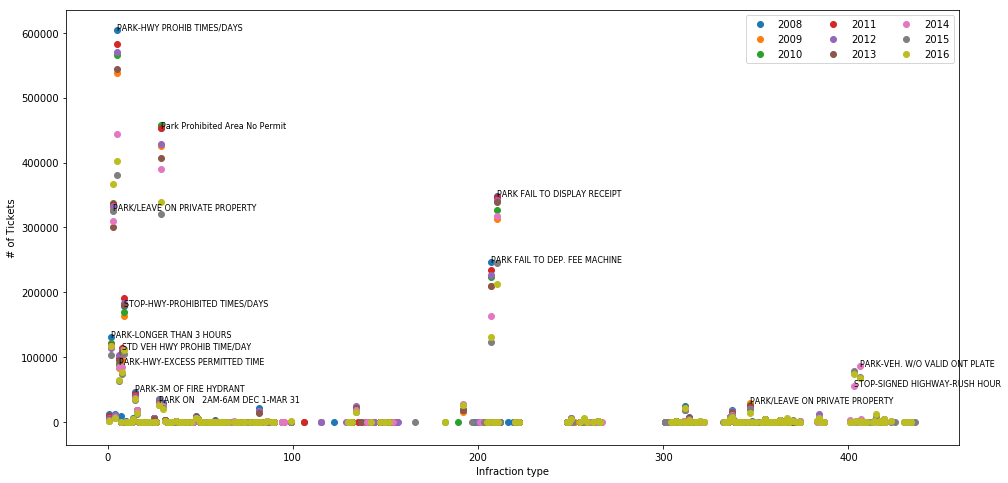

In [44]:
plt.figure(figsize=[16, 8])
plt.ylabel('# of Tickets')
plt.xlabel('Infraction type')
for year in range(0, len(tickets)):
    plt.scatter(tickets[year]['Distribution'][:, 0], tickets[year]['Distribution'][:, 1])

# add texts to improve visualization 
already_shown = []
for year in range(0, len(tickets)):
    sorted_ticket = np.sort(tickets[year]['Distribution'][:, 1])[::-1]
    for j in range(0, 11):
        L = np.where(tickets[year]['Distribution'][:, 1] == sorted_ticket[j])[0][0]
        if tickets[year]['Distribution'][L, 0] in already_shown:
            continue
        else:
            already_shown.append(tickets[year]['Distribution'][L, 0])
            idx = np.where(tickets[year]['code_description'][:, 0] == tickets[year]['Distribution'][L, 0])
            plt.text(tickets[year]['Distribution'][L, 0], tickets[year]['Distribution'][L, 1],
                     tickets[year]['code_description'][idx, 1][0][0], fontsize=8)

plt.legend(years, ncol=3, loc=0)

In [41]:
sorted_ticket

array([401636, 367638, 339145, 213327, 131511, 116498, 110457,  76414,
        74267,  68271,  64334,  35490,  26024,  25909,  21172,  19879,
        15933,  14687,  13334,  12787,   8385,   6567,   6320,   6254,
         6089,   6088,   5391,   4938,   4483,   4373,   3936,   3932,
         2946,   2476,   2164,   1949,   1926,   1907,   1765,   1621,
         1340,   1324,   1168,   1168,   1141,   1103,   1076,    993,
          991,    969,    920,    752,    726,    721,    627,    562,
          547,    522,    520,    327,    318,    279,    272,    230,
          215,    212,    187,    185,    185,    178,    177,    145,
          139,    135,    130,    125,    119,    111,    111,     87,
           79,     73,     72,     66,     64,     60,     58,     58,
           55,     50,     50,     49,     48,     39,     39,     37,
           36,     32,     31,     27,     26,     24,     21,     20,
           20,     19,     19,     19,     17,     16,     16,     13,
      

Plot total number of tickets and total revenues per month for different years. 

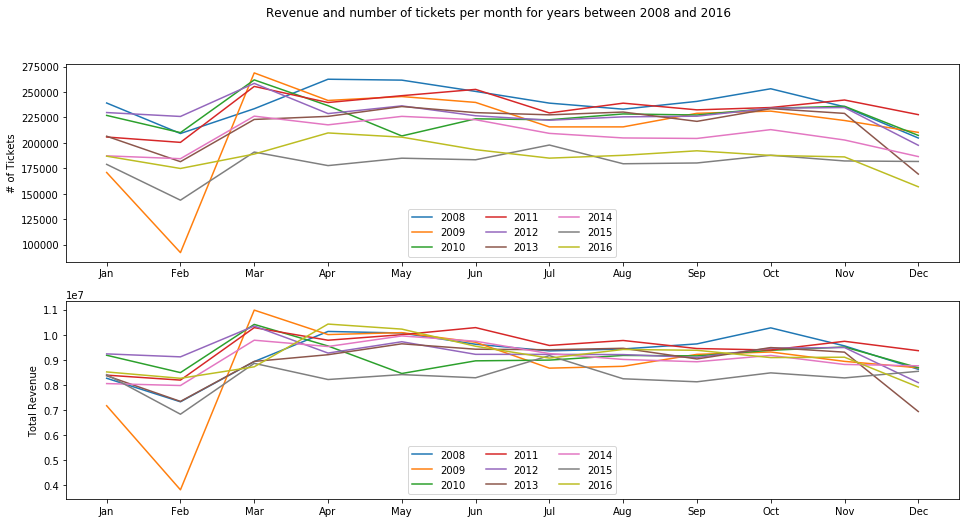

In [33]:
plt.figure(figsize=[16, 8])
plt.subplot(2, 1, 1)
plt.ylabel('# of Tickets')
plt.xticks(range(1, 13), months)
for year in range(0, len(tickets)):
    plt.plot(range(1, 13), tickets[year]['Per_month'][:, 1])
plt.legend(years, ncol=3, loc=8)

plt.subplot(2, 1, 2)
plt.ylabel('Total Revenue')
plt.xticks(range(1, 13), months)
for year in range(0, len(tickets)):
    plt.plot(range(1, 13), tickets[year]['Per_month'][:, 2])
plt.legend(years, ncol=3, loc=8)
plt.suptitle('Revenue and number of tickets per month for years between 2008 and 2016')

Plot total number of tickets and total revenues per weekday and quarterly for different years

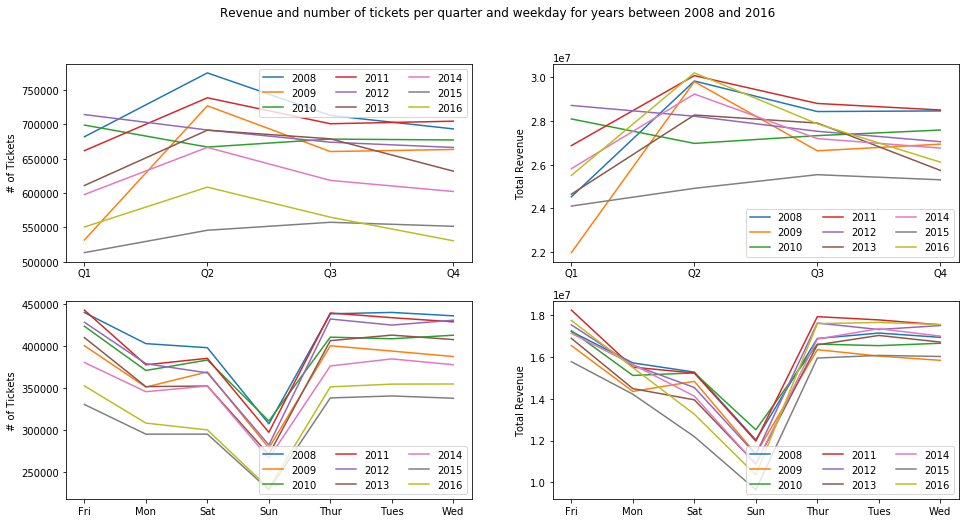

In [34]:
plt.figure(figsize=[16, 8])
plt.subplot(2, 2, 1)
plt.ylabel('# of Tickets')
plt.xticks(range(1, 5), ['Q1', 'Q2', 'Q3', 'Q4'])
for year in range(0, len(tickets)):
    plt.plot(range(1, 5), tickets[year]['Per_quarter'][:, 1])
plt.legend(years, ncol=3, loc=1)

plt.subplot(2, 2, 2)
plt.ylabel('Total Revenue')
plt.xticks(range(1, 5), ['Q1', 'Q2', 'Q3', 'Q4'])
for year in range(0, len(tickets)):
    plt.plot(range(1, 5), tickets[year]['Per_quarter'][:, 2])
plt.legend(years, ncol=3, loc=4)

plt.subplot(2, 2, 3)
plt.ylabel('# of Tickets')
plt.xticks(range(1, 8), weekdays)
for year in range(0, len(tickets)):
    plt.plot(range(1, 8), tickets[year]['Per_weekday'][:, 1])
plt.legend(years, ncol=3, loc=4)

plt.subplot(2, 2, 4)
plt.ylabel('Total Revenue')
plt.xticks(range(1, 8), weekdays)
for year in range(0, len(tickets)):
    plt.plot(range(1, 8), tickets[year]['Per_weekday'][:, 2])
plt.legend(years, ncol=3, loc=4)

plt.suptitle('Revenue and number of tickets per quarter and weekday for years between 2008 and 2016')


Plot total number of tickets and total revenues per day and per hour for different years

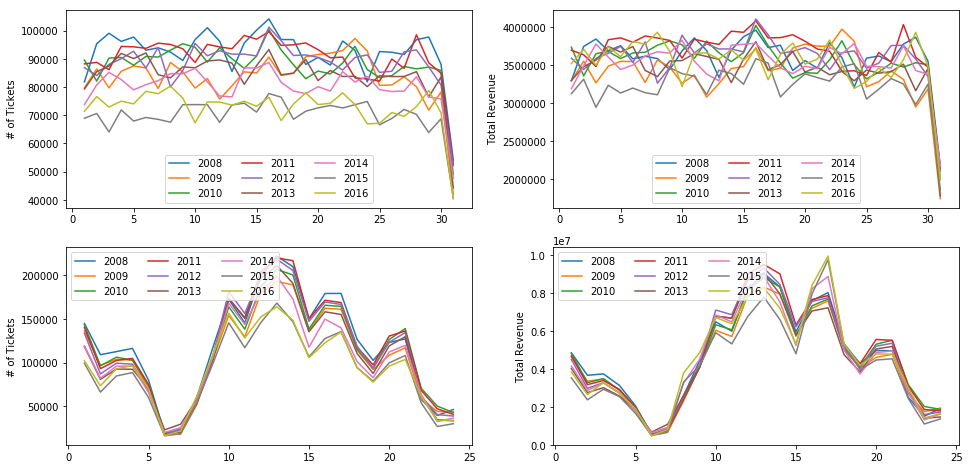

In [36]:
plt.figure(figsize=[16, 8])
plt.subplot(2, 2, 1)
plt.ylabel('# of Tickets')
for year in range(0, len(tickets)):
    plt.plot(range(1, 32), tickets[year]['Per_day'][:, 1])
plt.legend(years, ncol=3, loc=8)

plt.subplot(2, 2, 2)
plt.ylabel('Total Revenue')
for year in range(0, len(tickets)):
    plt.plot(range(1, 32), tickets[year]['Per_day'][:, 2])
plt.legend(years, ncol=3, loc=8)

plt.subplot(2, 2, 3)
plt.ylabel('# of Tickets')
for year in range(0, len(tickets)):
    plt.plot(range(1, 25), tickets[year]['Per_hour'][:, 1])
plt.legend(years, ncol=3, loc=2)

plt.subplot(2, 2, 4)
plt.ylabel('Total Revenue')
for year in range(0, len(tickets)):
    plt.plot(range(1, 25), tickets[year]['Per_hour'][:, 2])
plt.legend(years, ncol=3, loc=2)


Let's see what are the most common infraction per hour for years between 2008 and 2016

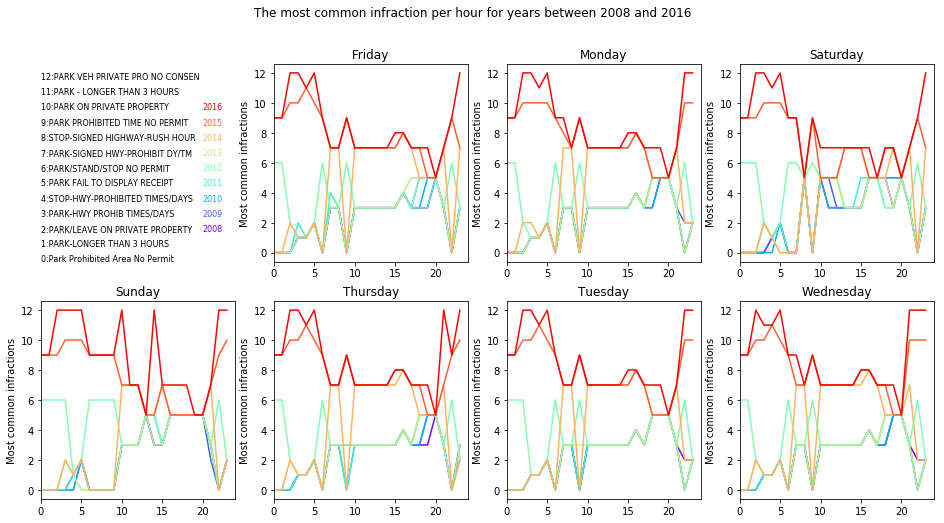

In [37]:
day_hr_infraction = pd.DataFrame()
for year in range(0, len(tickets)):
    for day in range(0, len(weekdaysF)):
        day_idx0 = np.where(tickets[year]['week_hour_code'][0:, :] == weekdaysF[day])[0][0] # start index
        if day == len(weekdaysF) - 1:
            day_idx1 = len(tickets[year]['week_hour_code'][0:, :])
        else:
            day_idx1 = np.where(tickets[year]['week_hour_code'][0:, :] == weekdaysF[day + 1])[0][0] #end index
        for hr in range(0, 24):
            hr_idx0 = np.where(tickets[year]['week_hour_code'][day_idx0:day_idx1, 1] == hr)[0][0] + day_idx0 #start index
            if hr == 23:
                hr_idx1 = day_idx1
            else:
                hr_idx1 = np.where(tickets[year]['week_hour_code'][day_idx0:day_idx1, 1] == (hr + 1))[0][0] + day_idx0 #end index
            max_count_idx = np.argmax(tickets[year]['week_hour_code'][hr_idx0:hr_idx1, 3]) + hr_idx0  # count
            max_count_code = tickets[year]['week_hour_code'][max_count_idx, 2] # infraction code
            idx = np.where(tickets[year]['code_description'][:, 0] == max_count_code) 
            max_count_desc = tickets[year]['code_description'][idx, 1] # infraction description 

            day_hr_infraction = day_hr_infraction.append(
                {'year': years[year], 'day': weekdaysF[day], 'hour': hr, 'code': max_count_code,
                 'desc': max_count_desc[0][0]}, ignore_index=True)

plt.figure(figsize=[16, 8])
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(years)))

lebels = day_hr_infraction.desc.unique()
plt.subplot(2, 4, 1)
plt.ylim([0, len(lebels)])
plt.xlim([0, 24])
plt.axis('off')

for i in range(0, len(lebels)):
    plt.text(0, i, str(i) + ':' + lebels[i], fontsize=8)

for day in range(0, len(weekdaysF)):
    for year in range(0, len(tickets)):
        plt.subplot(2, 4, day + 2)
        plt.xlim([0, 24])
        hours = day_hr_infraction[
            (day_hr_infraction.day == weekdaysF[day]) & (day_hr_infraction.year == years[year])].hour.values
        descp = day_hr_infraction[
            (day_hr_infraction.day == weekdaysF[day]) & (day_hr_infraction.year == years[year])].desc.values
        loc2 = np.array([-1] * 24)
        for i in range(0, len(lebels)):
            loc2[np.where(lebels[i] == descp[range(0, 24)])[0]] = i
        plt.plot(range(0, 24), loc2, c=colors[year])
        plt.title(weekdaysF[day])
        plt.ylabel('Most common infractions')
plt.suptitle('The most common infraction per hour for years between 2008 and 2016')
plt.subplot(2, 4, 1)
for i in range(0, len(tickets)):
    plt.text(20, 2 + i, str(2008 + i), color=colors[i], fontsize=8)

In [39]:
day_hr_infraction

,code,day,desc,hour,year
0,29.0,Friday,Park Prohibited Area No Permit,0.0,2008.0
1,29.0,Friday,Park Prohibited Area No Permit,1.0,2008.0
2,29.0,Friday,Park Prohibited Area No Permit,2.0,2008.0
3,2.0,Friday,PARK-LONGER THAN 3 HOURS,3.0,2008.0
4,2.0,Friday,PARK-LONGER THAN 3 HOURS,4.0,2008.0
5,3.0,Friday,PARK/LEAVE ON PRIVATE PROPERTY,5.0,2008.0
6,29.0,Friday,Park Prohibited Area No Permit,6.0,2008.0
7,5.0,Friday,PARK-HWY PROHIB TIMES/DAYS,7.0,2008.0
8,5.0,Friday,PARK-HWY PROHIB TIMES/DAYS,8.0,2008.0
9,29.0,Friday,Park Prohibited Area No Permit,9.0,2008.0


Finally, we can find streets with the largest total fines for years between 2008 and 2016

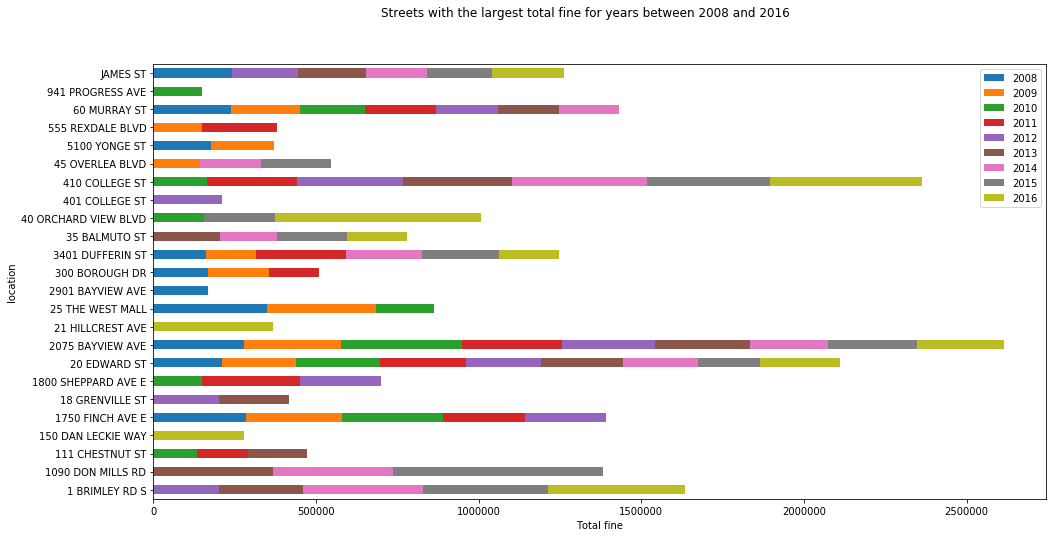

In [38]:
top_streets = pd.DataFrame()
for year in range(0, len(tickets)):
    for street in range(0, 10):
        top_streets = top_streets.append({'year': year + 2008, 'location': tickets[year]['top_streets'][street, 0],
                                          'amount': tickets[year]['top_streets'][street, 1]}, ignore_index=True)
dfs = []
for year in range(2008, 2017):
    dfs.append(top_streets[top_streets['year'] == year].drop('year', 1).set_index('location').rename(
        columns={'amount': str(year)}))

dfs_final = pd.DataFrame()
for year in range(0, len(dfs)):
    dfs_final = dfs_final.join(dfs[year], how='outer')

dfs_final.plot.barh(stacked=True, figsize=[16, 8])
plt.xlabel('Total fine')
plt.suptitle('Streets with the largest total fine for years between 2008 and 2016')

In [40]:
top_streets

,amount,location,year
0,349390.0,25 THE WEST MALL,2008.0
1,283410.0,1750 FINCH AVE E,2008.0
2,279610.0,2075 BAYVIEW AVE,2008.0
3,242880.0,JAMES ST,2008.0
4,237710.0,60 MURRAY ST,2008.0
5,209805.0,20 EDWARD ST,2008.0
6,177970.0,5100 YONGE ST,2008.0
7,167410.0,2901 BAYVIEW AVE,2008.0
8,166550.0,300 BOROUGH DR,2008.0
9,160430.0,3401 DUFFERIN ST,2008.0
